# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 05 апреля 18:00 Сдача **очная** на онлайн занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0920, Задание 2] Фамилия Имя.



**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Решение:***

$\nabla_w Q(w) = \frac{1}{n}\nabla_w (\langle X, w \rangle - y)^T(\langle X, w \rangle - y) + \nabla_w (\frac{1}{C} w^Tw) = \nabla_w (\frac{1}{n}(w^TX^TXw - y^TXw - Xwy + y^Ty) + \frac{1}{C} w^T w) = \frac{1}{n} (2X^TXw-2X^Ty) + 2\frac{1}{C} w$

$$w_{new} = (1-\frac{2\alpha}{C})w_{old} - \frac{2\alpha}{n}X^T(Xw-y)$$



Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Решение***

$L(w) = -\frac{1}{n}(\sum\limits_{i=1}^n y_i log \sigma (\langle x_i, w \rangle) + (1 - y_i) log(1 - \sigma (\langle x_i, w \rangle)))$

$\sigma'(x) = \sigma(x)(1 - \sigma(x))$

$\Rightarrow \nabla_w L(w) = -\frac{1}{n}(\sum\limits_{i=1}^n y_i \frac{1}{\sigma (\langle x_i, w \rangle)}\sigma(\langle x_i, w \rangle)(1 - \sigma(\langle x_i, w \rangle))x_i  - (1 - y_i) \frac{1}{1 - \sigma (\langle x_i, w \rangle)}\sigma(\langle x_i, w \rangle)(1 - \sigma(\langle x_i, w \rangle)) x_i) + \frac{2}{C}w = -\frac{1}{n}(\sum\limits_{i=1}^n y_i (1 - \sigma(\langle x_i, w \rangle))x_i  - (1 - y_i) \sigma(\langle x_i, w \rangle) x_i) + \frac{2}{C}w = -\frac{1}{n}(\sum\limits_{i=1}^n x_i (y_i - \sigma(\langle x_i, w \rangle))) + \frac{2}{C}w$

$$w_{new} = (1 - \frac{2 \alpha}{C})w_{old} - \frac{\alpha}{n}X^T(\sigma(Xw) - y)$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Решение:***

$H(w) = \nabla_w \nabla_w Q(w) = \nabla_w((X^TX + X^TX)w) = X^TX + X^TX = 2X^TX$

$H_{ij} = 2x_ix_j$, из максимальности ранга $X$ следует, что строки в ней линейно независимы $\Rightarrow H$ - матрица Грама $\Rightarrow$ положительно определена.

$Q(w) = \frac{1}{N}(Xw - y)^T(Xw - y) + \alpha w^Tw$

$\nabla_w Q_w = 2X^TXw-2X^Ty + 2\alpha w=0$

$\Rightarrow (X^TX + \alpha I)w = X^Ty$

$\Rightarrow w = (X^TX + \alpha I)^{-1}X^Ty$

Если в $X$ есть л/з признаки, то $X^TX$ будет вырожденной. Добавление $\alpha I$ делает матрицу $(X^TX + \alpha I)$ невырожденной.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Решение:***

$\frac{\partial}{\partial a_i} E(L|x_i) = - \frac{p(y_i = 1|x_i)}{a_i} + \frac{p(y_i = 0|x_i)}{1 - a_i}$

При $a_i = p(y_i = 1|x_i)$, $\frac{\partial}{\partial a_i} E(L|x_i) = 0$

$\frac{\partial^2}{\partial a_i^2} E(L|x_i) = \frac{p(y_i = 1|x_i)}{a_i^2} + \frac{p(y_i = 0|x_i)}{(1 - a_i)^2}$

При $a_i = p(y_i = 1|x_i)$, $\frac{\partial^2}{\partial a_i^2} E(L|x_i) = \frac{1}{p(y_i = 1|x_i)} + \frac{1}{1 - p(y_i = 1|x_i)} = \frac{1}{p(y_i = 1|x_i)p(y_i = 0|x_i)} > 0$

$\Rightarrow a_i = p(y_i = 1|x_i)$ - точка минимума.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Решение:***

Потому что $w_0$ отвечает за сдвиг.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    index = np.arange(X.shape[0])
    if shuffle == True:
        np.random.shuffle(index)
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[index[i:i+batch_size]]
        y_batch = y[index[i:i+batch_size]]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [7]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1/(1 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator=batch_generator, C=1, alpha=0.01,
                max_epoch=10, model_type='lin_reg', batch_size=1,
                threshold=0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.threshold = threshold

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        a = np.dot(X_batch, self.weights)
        if self.model_type == 'lin_reg':
            loss = np.mean((a - y_batch)**2)
        elif self.model_type == 'log_reg':
            a = sigmoid(a)
            loss = -np.mean(y_batch*np.log(a) + (1 - y_batch)*np.log(1 - a))
        loss += np.sum(self.weights**2)/self.C

        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        a = np.dot(X_batch, self.weights)
        if self.model_type == 'lin_reg':
            loss_grad = 2*np.dot(X_batch.T, (a - y_batch))
        if self.model_type == 'log_reg':
            a = sigmoid(a)
            loss_grad = np.dot(X_batch.T, (a - y_batch))
        loss_grad = loss_grad / y_batch.shape[0]
        loss_grad += 2*np.r_[0, self.weights[1:]] / self.C

        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Нужно инициализровать случайно веса
        X = np.c_[np.ones(shape=(X.shape[0])), X]
        self.weights = np.random.rand(X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y,
                                  batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        y_hat = np.dot(X, self.weights[1:])
        if self.model_type == 'log_reg':
            y_hat = sigmoid(y_hat)
        y_hat = (y_hat > self.threshold).astype(int)

        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf, X):
    print(f'{clf.model_type}: {clf.weights}')

    def line(X):
        return -(clf.weights[1]*X + clf.weights[0])/clf.weights[2]
    plt.plot(X[:, 0], line(X[:, 0]), label=clf.model_type)

lin_reg: [-0.14289096  0.09443882 -0.16114088]
log_reg: [-2.0984515   0.60591371 -0.42827484]


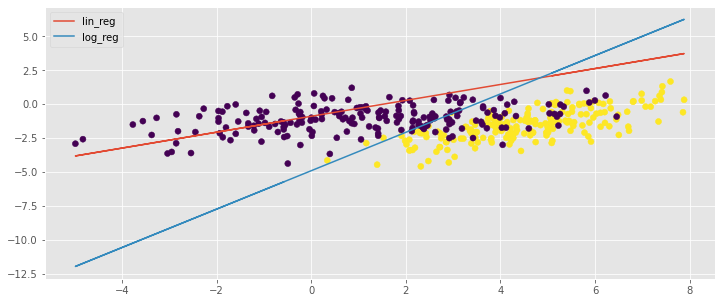

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

lin_reg = MySGDClassifier(model_type='lin_reg', C=100, batch_size=20,
                          alpha=0.06, max_epoch=30)
lin_reg.fit(X, y)
plot_decision_boundary(lin_reg, X)

log_reg = MySGDClassifier(model_type='log_reg', C=100, batch_size=20,
                          alpha=0.05, max_epoch=30)
log_reg.fit(X, y)
plot_decision_boundary(log_reg, X)

plt.legend()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

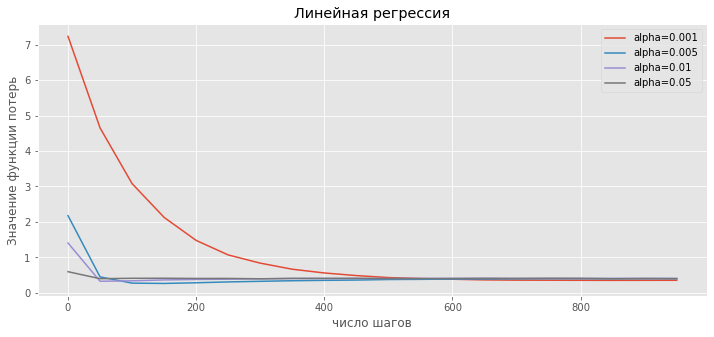

In [12]:
N = 50
plt.title('Линейная регрессия')
plt.xlabel('число шагов')
plt.ylabel('Значение функции потерь')
alpha_val = [0.001, 0.005, 0.01, 0.05]
for alpha in alpha_val:
    clf_lin_reg = MySGDClassifier(alpha=alpha, batch_size=100, max_epoch=1,
                                  model_type='lin_reg')
    clf_lin_reg.fit(X, y)
    lin_reg_loss = np.asarray(clf_lin_reg.errors_log['loss'])
    mean_lin_reg_loss = np.asarray([np.mean(lin_reg_loss[i:i + N])
                                   for i in range(0, lin_reg_loss.shape[0], N)])
    plt.plot(range(0, lin_reg_loss.shape[0], N),
             mean_lin_reg_loss, label=f'alpha={alpha}')
plt.legend()
plt.show()

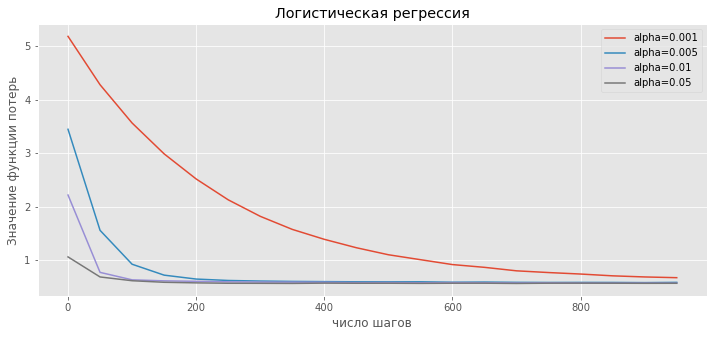

In [13]:
N = 50
plt.title('Логистическая регрессия')
plt.xlabel('число шагов')
plt.ylabel('Значение функции потерь')
alpha_val = [0.001, 0.005, 0.01, 0.05]
for alpha in alpha_val:
    clf_log_reg = MySGDClassifier(alpha=alpha, batch_size=100,
                                  max_epoch=1, model_type='log_reg')
    clf_log_reg.fit(X, y)
    log_reg_loss = np.asarray(clf_log_reg.errors_log['loss'])
    mean_log_reg_loss = np.asarray([np.mean(log_reg_loss[i:i + N])
                                   for i in range(0, log_reg_loss.shape[0], N)])
    plt.plot(range(0, log_reg_loss.shape[0], N),
             mean_log_reg_loss, label=f'alpha={alpha}')
plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

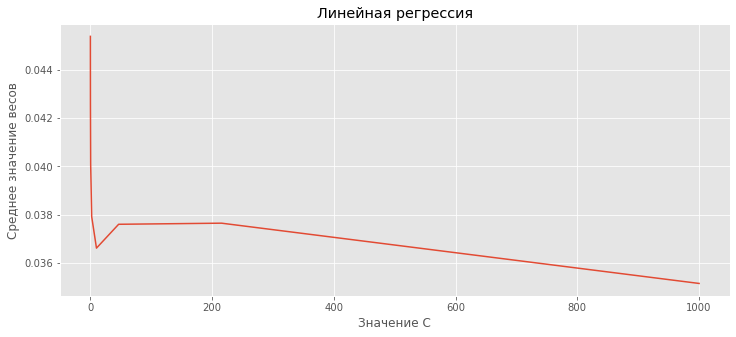

In [14]:
plt.title('Линейная регрессия')
plt.xlabel('Значение С')
plt.ylabel('Среднее значение весов')
mean_weights = []
for C in np.logspace(3, -3, 10):
    clf_lin_reg = MySGDClassifier(alpha=0.0001, batch_size=20,
                                  max_epoch=10, model_type='lin_reg', C=C)
    clf_lin_reg.fit(X, y)
    mean_weights.append(np.mean(clf_lin_reg.weights))
plt.plot(np.logspace(3, -3, 10), mean_weights)
plt.show()

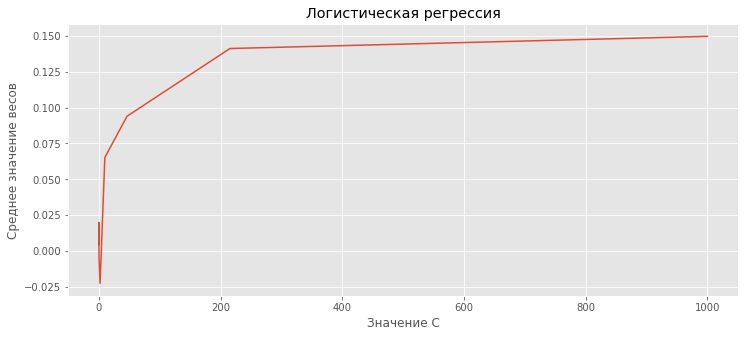

In [15]:
plt.title('Логистическая регрессия')
plt.xlabel('Значение С')
plt.ylabel('Среднее значение весов')
mean_weights = []
for C in np.logspace(3, -3, 10):
    clf_log_reg = MySGDClassifier(alpha=0.0001, batch_size=20,
                                  max_epoch=10, model_type='log_reg', C=C)
    clf_log_reg.fit(X, y)
    mean_weights.append(np.mean(clf_log_reg.weights))
plt.plot(np.logspace(3, -3, 10), mean_weights)
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [16]:
doc_to_title = {}
with open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [17]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [18]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)

In [20]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [21]:
my_clf = MySGDClassifier(batch_size=100, model_type='lin_reg')
clf = SGDClassifier()

In [22]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(f1_score(y_pred=clf.predict(X_train), y_true=y_train))
print(f1_score(y_pred=my_clf.predict(X_train), y_true=y_train))

0.5860170198564992
0.20952380952380953


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [23]:
kf = GroupKFold(n_splits=3)


def cross_val_score(X, y, clf):
    pred = []
    for train, test in kf.split(X, groups=groups_train):
        clf.fit(X[train], y[train])
        pred.append(f1_score(y[test], clf.predict(X[test])))
    return np.mean(pred)

In [24]:
model_type_range = ['lin_reg', 'log_reg']
C_range = np.logspace(3, -3, 5)
max_epoch_range = range(1, 11)
alpha_range = np.logspace(-4, -1, 5)
scores = []
params = []
for model_type in model_type_range:
    for C in C_range:
        for max_epoch in max_epoch_range:
            for alpha in alpha_range:
                my_clf = MySGDClassifier(batch_size=100, model_type=model_type,
                                         C=C, max_epoch=max_epoch, alpha=alpha)
                scores.append(cross_val_score(X_train, y_train, my_clf))
                params.append([model_type, C, max_epoch, alpha])


In [25]:
opt_params = params[np.argmax(scores)]

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [26]:
scores = []
tres = []
for threshold in np.arange(0.001, 0.4, 0.001):
    my_clf = MySGDClassifier(batch_size=100, model_type=opt_params[0],
                             C=opt_params[1], max_epoch=opt_params[2],
                             alpha=opt_params[3], threshold=threshold)
    scores.append(cross_val_score(X_train, y_train, my_clf))
    tres.append(threshold)

In [27]:
opt_params.append(tres[np.argmax(scores)])

In [28]:
my_clf = MySGDClassifier(batch_size=100, model_type=opt_params[0],
                         C=opt_params[1], max_epoch=opt_params[2],
                         alpha=opt_params[3], threshold=opt_params[4])
cross_val_score(X_train, y_train, my_clf)

0.5794415246403304

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [29]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id = new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, pair_id, title))

X_test = []
pairs_id = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, pair_id, title) in enumerate(docs):
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            *_, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
        pairs_id.append(pair_id)
X_test = np.array(X_test)
print(X_test.shape)

(16627, 15)


In [30]:
X_test = scaler.transform(X_test)
pred = my_clf.predict(X_test)
df = pd.DataFrame()
df['pair_id'] = pairs_id
df['target'] = pred

df.to_csv("pred.csv", header=True, index=False)

In [31]:
df[df['target'] == 0]

,pair_id,target
6,11697,0
7,11698,0
9,11700,0
11,11702,0
15,11706,0
...,...,...
16583,28274,0
16584,28275,0
16587,28278,0
16598,28289,0


In [32]:
df1 = pd.read_csv('pred.csv')
df1[df1['target'] == 1]

,pair_id,target
0,11691,1
1,11692,1
2,11693,1
3,11694,1
4,11695,1
...,...,...
16622,28313,1
16623,28314,1
16624,28315,1
16625,28316,1


***Никнейм на Kaggle: Alexander Drobyshev***

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***